In [1]:
%matplotlib widget

In [2]:
from pysketcher import *

In [3]:
from ipywidgets import FloatSlider, AppLayout, Label, HBox

In [22]:
from IPython.display import SVG, display

In [4]:
import sys
from ruamel.yaml import YAML
from math import tan, radians, sin, cos

In [5]:
myfig={}

In [6]:
yaml = YAML()

In [7]:
gw = """\
libraries: ["from math import tan, radians, sin, cos","from pysketcher import *"]
fontsize: 18
g: 9.81              # constant gravity
theta: 30.0          # inclined plane angle
L: 10.0              # scene length
a: 1.0               #
xmin: 0.0
ymin: -3.0
r: 1.0
setframe:
    action: "drawing_tool.set_coordinate_system(xmin=xmin, xmax=xmin+1.5*L,ymin=ymin, ymax=ymin+L+1,instruction_file='tmp_mpl.py')"
setblackline:
    action: "drawing_tool.set_linecolor('black')"
B: point(a+L,0)
A: point(a,tan(radians(theta))*L)
normal_vec: point(sin(radians(theta)),cos(radians(theta)))
tangent_vec: point(cos(radians(theta)),-sin(radians(theta)))
help_line: Line(A,B)
x: a + 3*L/10.
y: help_line(x=x)    
contact: point(x, y)    
c: contact + r*normal_vec
outer_wheel: 
    formula: Circle(c, r)
    style:
        linecolor: blue
        filled_curves: blue
hole: 
    formula: Circle(c, r/2.)
    style:
        linecolor: blue
        filled_curves: white
N: 
    formula: Force(contact - 2*r*normal_vec, contact, r'$N$', text_pos='start')
    style:
        linecolor: black
mg: 
    formula: Gravity(c, 3*r, text='$Mg$')
    style:
        linecolor: black
wheel: 
    formula: "Composition({'outer': outer_wheel, 'inner': hole})"   
    style:
        shadow: 4
body: 
    formula: "Composition({'wheel': wheel, 'N': N, 'mg': mg})"
    style:
        linecolor: black
wall: 
    formula: Wall(x=[A[0], B[0]], y=[A[1], B[1]], thickness=-0.25,transparent=False)
    style:
        linecolor: black    
angle: 
    formula: "Arc_wText(r'$<bslash>theta$', center=B, radius=3, start_angle=180-theta, arc_angle=theta, fontsize=fontsize)"
    style:
        linecolor: black
        linewidth: 1
ground: 
     formula: Line((B[0]-L/10., 0), (B[0]-L/2.,0))
     stlye:
         linecolor: black
         linestyle: dashed
         linewidth: 1
x_const: 
    formula: Line(contact, contact + point(0,4))
    style:
        linestyle: dotted
    transform: rotate(-theta, contact)
x_axis: 
    formula: "Axis(start=contact+ 3*r*normal_vec, length=4*r,label='$x$', rotation_angle=-theta)"
fixed: 
    formula: "Composition({'angle': angle, 'inclined wall': wall,'ground': ground,'x start': x_const, 'x axis': x_axis})"
fig: 
    formula: "Composition({'body': body, 'fixed elements': fixed})"
"""

In [8]:
gwd = yaml.load(gw)
#print(gwd['g'])
#yaml.dump(gwd, sys.stdout)

In [9]:
for _k in list(gwd.keys()):
    if _k == "stop":
        break
    _c = gwd[_k]
    _t = str(type(_c))
    if _k == "libraries":
        for l in _c:
            exec(l,myfig)
    #print(_k, _c, _t)
    if _t == "<class 'ruamel.yaml.scalarfloat.ScalarFloat'>" or \
       _t == "<class 'str'>" or _t == "<class 'int'>":
        _formula = f"{_k} = {_c}".replace("<bslash>","\\") 
        #print(_formula)
        exec(_formula,myfig)
    elif _t == "<class 'ruamel.yaml.comments.CommentedMap'>":
        #print(_c)
        _keys = list(_c.keys())
        #print(_keys)
        if 'formula' in _keys:
            _formula = f"{_k} = {_c['formula']}".replace("<bslash>","\\")
            #print(_formula)
            exec(_formula,myfig)
        if 'style' in _keys:
            for _style in _c["style"]:
                #  x_const.set_linestyle('dotted')
                _param = _c["style"][_style]
                __t = str(type(_param))
                #print(__t)
                if __t == "<class 'int'>":
                    _style = f"{_k}.set_{_style}({_param})"
                else:
                    _style = f"{_k}.set_{_style}('{_param}')"
                #print(_style)
                exec(_style,myfig)
        if 'transform' in _keys:
            #print(_c['transform'])
            if str(type(_c['transform'])) == "<class 'str'>":
                _t = f"{_k}.{_c['transform']}"
                #print(_t)
                exec(_t,myfig)
            else:
                for _transform in _c["transform"]:
                #  x_const.rotate(-theta, contact)
                    _t = f"{_k}.{_c['transform']}"
                    #print(_t)
                    exec(_t,myfig)
        if "action" in _keys:
            _action = _c["action"]
            #print(_action)
            exec(_action,myfig)

In [10]:
d = myfig['fig'].draw()

In [11]:
drawing_tool.display()

In [12]:
def position(t):
    """Position of center point of wheel."""
    global tangent_vec,c,myfig
    return myfig['c'] + 0.5*myfig['g']*t**2*myfig['tangent_vec']
t = 0
def move(change):
    global fig,t,label,x,x0,dt
    dt = change.new - t 
    t = change.new
    drawing_tool.erase()
    x = position(t)
    x0 = position(t-dt)
    displacement = x - x0    
    myfig['fig']['body'].translate(displacement)
    myfig['fig'].draw()
    label.value = f"p:{x}"

In [13]:
slider = FloatSlider(
    orientation='horizontal',
    description='Time:',
    value=0.0,
    min=0.0,
    max=1.0,
    step = 1.0 / 30
)
slider.observe(move, 'value')

In [14]:
label = Label(value="")

In [15]:
AppLayout(
    center=drawing_tool.mpl.gcf().canvas,
    footer=HBox([slider,label]),
    pane_heights=[0, 6, 1]
)
#drawing_tool.mpl.ion()

AppLayout(children=(HBox(children=(FloatSlider(value=0.0, description='Time:', max=1.0, step=0.033333333333333…

In [16]:
drawing_tool.mpl.ion()

In [ ]:
myfig['fig'].graphviz_dot('fig')

In [ ]:
!dot -Tpng -o fig.png fig.dot

![](fig.png)

In [ ]:
drawing_tool.mpl.gcf().canvas.print_png("fig1.png")

![](fig1.png)

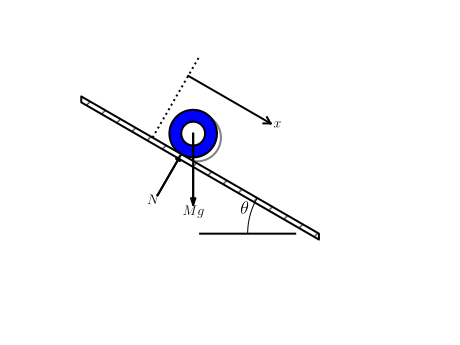

In [26]:
from io import BytesIO
f = BytesIO()
drawing_tool.mpl.savefig(f, format="svg")
display(SVG(f.getvalue()))